In [1]:
import numpy as np
import pickle
import matplotlib.pyplot as plt
import pandas as pd
import multiprocessing as mp
import os
import healpy as hp
import requests

from astropy import units as u
from astropy.coordinates import SkyCoord
from astropy.time import Time
from astropy.io.votable import parse
from astropy.io import fits
from astropy.wcs import WCS
from astropy.wcs import NoConvergence
from astropy.table import Table, vstack
from astroquery.imcce import Skybot
from astroquery.jplhorizons import Horizons

#from queryMPC import runMPCRequests
#from queryMPC import matchSingleVisit
#from plottingTools import makeStamps

pd.options.mode.chained_assignment = None  # default='warn'

In [12]:
# Match the objects from MPC with pixel locations in the DECam NEO Survey
# Can comment this out if you don't want to select on slow movers (total_motion is arcsec/hr.)
# Cut the dataframe based on desired brightness and speed

class FindObjects():
    def __init__(self):
        self.testVisit = None
        self.ccdNum = None
        self.dataPath = None
        
    def matchCcds(self, ccd):
        """This is a wrapper for matchSingleVisit.
        It allows it to easily run in parallel with a simple
        pool.map() call.
        """
        #visitDF = cutDF.query('visit_id == %i' % visit)
        #visitDF = visitDF.reset_index(drop=True)
        visitLocal=self.testVisit
        visitDF = self.matchSingleVisitCcd(self.cutDF,visitLocal,ccd,self.dataPath)
        #print('Processed ccd {}'.format(ccd))
        return(visitDF)

    def matchVisits(self, visit):
        """This is a wrapper for matchSingleVisit.
        It allows it to easily run in parallel with a simple
        pool.map() call.
        """
        #visitDF = cutDF.query('visit_id == %i' % visit)
        #visitDF = visitDF.reset_index(drop=True)
        ccd=self.ccdNum
        visitDF = self.matchSingleVisitCcd(self.cutDF,visit,ccd,self.dataPath)
        #print('Processed visit {}'.format(visit))
        return(visitDF)

    def matchSingleVisitCcd(self, visitDF, visit, ccd, dataPath, verbose=False):
        """Match the MPC object RA and DEC to pixel coorinates in the DECam NEO Survey
        Inputs-
            visitDF : Dataframe from runMPCRequests.
                It should only contain values from a single visit, although it may
                have multiple objects in that visit.
                Can be cut on magnitude, etc. if desired
            dataPath : Path to the DECam NEO Survey warps.
            verbose : Verbosity flag for print output

        Outputs-
            visitDF : Updated Dataframe with object->pixel relationships.
        """    

        i=ccd
        if verbose:
            print('Processing visit {}.'.format(visit))
        # Iterate over all moving objects (rows) in the visitDF
        obj_row = visitDF[visitDF['visit']==visit]
        # Set ra and dec and use them to generate a SkyCoord object
        ra = obj_row['RA']
        dec = obj_row['DEC']
        c = SkyCoord(ra, dec, frame='icrs', unit=(u.deg, u.deg))
        # Iterate over CCDs
        # CCD 2 and 61 are broken on DECam and should be skipped
        if (i==2 or i==61):
            return(obj_row)
        if verbose:
            print('Processing ccd {} of 62.'.format(i))
        # Calculate the pixel values for the objects in the visit
        try:
            # Load only the fits header, changing the path for varying CCDs
            fitsHeader = fits.getheader('%s/%02i/%s.fits' % (dataPath,i,visit),1)
            # Load the world coordinate system and find the pixel values
            w = WCS(fitsHeader)
            x_pix, y_pix = c.to_pixel(w)
            # If the returned pixel values are on the given CCD, save the object
            if (x_pix < 2010) and (x_pix > 0) and (y_pix < 4100) and (y_pix > 0):
                if verbose:
                    print(obj_row['name'], ra, dec)
                    print(x_pix, y_pix)
                obj_row['x_pixel'] = x_pix
                obj_row['y_pixel'] = y_pix
                obj_row['ccd'] = i
        except:
            return(obj_row)
        return(obj_row)
    
    def getKBOList(self, pgNum):
        with open('PickledPointings.pkl', 'rb') as f:
            PointingGroups = pickle.load(f)
        PointingGroups = PointingGroups[pgNum]
        PointingGroups.drop_duplicates('visit_id',inplace=True)
        df = PointingGroups
        allTimes = []
        for i in range(len(PointingGroups)):
            date_obs = df['date_obs'].iloc[i].decode()#[2:-1]
            time_obj = Time(date_obs, format='iso', scale='utc')
            allTimes.append(time_obj.jd)
        allTimes = np.array(allTimes)
        #timesMask = np.logical_and(allTimes>2458576.714,allTimes<2458577.70862527)
        times = allTimes

        ra = PointingGroups['ra'].values
        dec = PointingGroups['dec'].values
        i=0
        field = (ra[i],dec[i])
        epoch = Time(times[i], format='jd')
        Results = Skybot.cone_search(field, 90*u.arcmin, epoch, location='W84')

        RA_rate = Results['RA_rate']
        DEC_rate = Results['DEC_rate']
        pixel = u.arcsec/.26
        RA_rate = RA_rate.to(pixel/u.day)
        DEC_rate = DEC_rate.to(pixel/u.day)

        totalRate = np.linalg.norm([RA_rate,DEC_rate],axis=0)
        Type = np.array([classtype[0:3] for classtype in np.array(Results['Type'])])
        KBOList = Results[Type=='KBO']['Name','RA','DEC','V']
        return(PointingGroups, KBOList)
    
def makeStamps(singleObject,imagePath,imagePlane='science',numCols=5,
               stampSize=[31,31]):
    """Generate postage stamps of an MPC object in the Lori Allen Dataset.
    
    INPUT-
        name: This is the name of the object for which to find the image.
            Names come from the query_MPC notebook that pulls data down from
            the Minor Planets Center.

        objectList: A pandas dataframe as generated by query_MPC.

        imagePath: The path to the stack of images from which to make stamps.

        numCols: The number of columns in the postage stamp subplot.

        imagePlane : From which plane of the fits file should the stamps be
            made? Acceptable options:
            'science' : The science image plane
            'mask' : The mask image plane
            'variance' : The varience image plane
    """
    totalLength = len(singleObject)
    # Set the plane number used for loading the data from a fits file
    if imagePlane == 'science':
        imagePlaneNum = 1
    elif imagePlane == 'mask':
        imagePlaneNum = 2
    elif imagePlane == 'variance':
        imagePlaneNum = 3

    # Find the number of subplots to make. Add one for the coadd.
    numPlots = len(singleObject)+1
    #numPlots=15
    # Compute number of rows for the plot
    numRows = numPlots // numCols
    # Add a row if numCols doesn't divide evenly into numPlots
    if (numPlots % numCols):
        numRows+=1
    # Add a row if numRows=1. Avoids an error caused by ax being 1D.
    if (numRows==1):
        numRows+=1
    # Generate the subplots, setting the size with figsize
    fig,ax = plt.subplots(nrows=numRows,ncols=numCols,
                          figsize=[3*numCols,3.5*numRows])
    try:
        objectMag = np.max(singleObject['V'])
    except:
        objectMag = -99.0
    # Find object velocity in pixels/day and the object angle in radians
    # total_motion is in arcsec/hr. DECam has .26arcsec/pixel ccd's. 24 hr/day.
    # Load initial and final object positions and calculate the trajectory angle
    findMotion = singleObject[singleObject['ccd']==singleObject['ccd'][0]]
    xi = np.array([findMotion['x_pixel'][0],
                   findMotion['y_pixel'][0]])
    xf = np.array([findMotion['x_pixel'][-1],
                   findMotion['y_pixel'][-1]])
    dx = xf-xi
    objectAngle = np.arctan2(dx[1],dx[0])
    dr = np.linalg.norm(dx)
    dt= findMotion['times'][-1] - findMotion['times'][0]
    objectVel = dr/dt
    xVel = dx[0]/dt
    yVel = dx[1]/dt
    
    if objectAngle<0:
        objectAngle += 2*np.pi
    # Turn off all axes. They will be turned back on for proper plots.
    for row in ax:
        for column in row:
            column.axis('off')

    stampEdge = (stampSize[0]-1)/2
    size = stampSize[0]
    x = np.linspace(-stampEdge, stampEdge, size)
    y = np.linspace(-stampEdge, stampEdge, size)
    sigma_x = 1.4
    sigma_y = 1.4

    x, y = np.meshgrid(x, y)
    gaussian_kernel = (1/(2*np.pi*sigma_x*sigma_y) 
        * np.exp(-(x**2/(2*sigma_x**2) + y**2/(2*sigma_y**2))))
    sum_pipi = np.sum(gaussian_kernel**2)
    noise_kernel = np.zeros(stampSize)
    mask_lims = 7
    x_mask = np.logical_or(x>mask_lims, x<-mask_lims)
    y_mask = np.logical_or(y>mask_lims, y<-mask_lims)
    mask = np.logical_or(x_mask,y_mask)
    noise_kernel[mask] = 1

    # Set the axis indexes. These are needed to plot the stamp in the correct subplot
    axi=0
    axj=1
    #print(totalLength)
    #mask = np.array(sorted(random.sample(range(1,totalLength),14)))
    #print(mask)
    maskedObject = singleObject#[mask]
    for i,row in enumerate(singleObject):
        # Get the Lori Allen visit id from the single object list
        visit_id = row['visit']
        ccd = row['ccd']
        # Get the x and y values from the first object in the cut list. Round to an integer.
        objectLoc = np.round([row['x_pixel'],row['y_pixel']])
        # Open up the fits file of interest using the pre-defined filepath string
        hdul = fits.open(os.path.join(imagePath,'{:02}/{}.fits'.format(ccd,visit_id)))

        # Generate the minimum and maximum pixel values for the stamps using stampSize
        xmin = int(objectLoc[0]-(stampSize[0]-1)/2+0.5)-1
        xmax = int(objectLoc[0]+(stampSize[0]-1)/2+0.5)
        ymin = int(objectLoc[1]-(stampSize[1]-1)/2+0.5)-1
        ymax = int(objectLoc[1]+(stampSize[1]-1)/2+0.5)

        im_dims = np.shape(hdul[imagePlaneNum].data)
        # Plot the stamp
        stampData = hdul[imagePlaneNum].data[ymin:ymax,xmin:xmax]
        #print(np.isnan(stampData))
        stampData[np.isnan(stampData)] = 0.0
        if i==0:
            coaddData=stampData
        else:
            coaddData+=stampData
        signal = np.sum(stampData*gaussian_kernel)
        noise = np.var(stampData*noise_kernel)
        SNR = signal/np.sqrt(noise*sum_pipi)
        #if (mask==i).any():
        if (True):

            im = ax[axi,axj].imshow(stampData,cmap=plt.cm.bone)
            ax[axi,axj].set_title(
                'ccd={} | visit={}\nSNR={:.2f}'.format(ccd,visit_id,SNR))
            ax[axi,axj].axis('on')
            # Compute the axis indexes for the next iteration
            if axj<numCols-1:
                axj+=1
            else:
                axj=0
                axi+=1
    im = ax[0,0].imshow(coaddData,cmap=plt.cm.bone)
    signal = np.sum(coaddData*gaussian_kernel)
    noise = np.var(coaddData*noise_kernel)
    SNR = signal/np.sqrt(noise*sum_pipi)
    ax[0,0].axis('on')
    _=ax[0,0].set_title('Coadd | SNR={:.2f}'.format(SNR))
    objectData = [singleObject['targetname'][0],objectMag,[xVel,yVel],objectVel,objectAngle,objectLoc]
    figTitle = '{}: {} image\nv_mag={}, velocity=[{:.2f},{:.2f}]={:.2f} px/day, angle={:.2f}\npixel=[{},{}]'
    fig.suptitle(figTitle.format(singleObject['targetname'][0],imagePlane,objectMag,xVel,yVel,objectVel,objectAngle,*objectLoc),
                 fontsize=16)
    return(coaddData,objectData)

def getPlots(PointingGroups, pgNum, KBOList, findObjects):
    pgObjectData = {}
    for KBONum,KBO in enumerate(KBOList):
        objectName = KBO['Name']
        df = PointingGroups
        allTimes = []
        for i in range(len(PointingGroups)):
            date_obs = df['date_obs'].iloc[i].decode()#[2:-1]
            time_obj = Time(date_obs, format='iso', scale='utc')
            allTimes.append(time_obj.jd)
        allTimes = np.array(allTimes)
        timesMask = np.logical_and(allTimes>2458576.714,allTimes<2458577.70862527)
        times = allTimes
        obj = Horizons(id=objectName, location='W84', epochs=times) #ccd 43
        orbits = obj.ephemerides(quantities='1, 9')
        orbits['visit'] = [int(visit) for visit in df['visit_id']]
        orbits['x_pixel'] = -99
        orbits['y_pixel'] = -99
        orbits['ccd'] = -99
        orbits['times'] = times
        #visitMask = [np.logical_and(orbits['visit']>=845580,orbits['visit']<=845682)]
        #orbits = orbits[visitMask]

        findObjects.dataPath = '/astro/store/epyc/users/smotherh/DECAM_Data_Reduction/pointing_groups_hyak/Pointing_Group_{0:03}/warps'.format(pgNum)
        findObjects.cutDF = orbits
        nightVisits = np.array(orbits['visit'])

        findObjects.testVisit = nightVisits[20]
        with mp.Pool(20) as pool:
            results = pool.map(findObjects.matchCcds,range(1,63))

        for j in range(62):
            foo = results[j]
            onCcd = foo[foo['ccd']>0]
            if len(onCcd)>0:
                findObjects.ccdNum = onCcd['ccd'][0]
                print(objectName+' is on ccd '+str(findObjects.ccdNum))
        if findObjects.ccdNum is None:
            print(objectName+' is not on any ccd')
        else:
            with mp.Pool(20) as pool:
                results = pool.map(findObjects.matchVisits,nightVisits)

            allResults = vstack(results)
            allResults = allResults[allResults['ccd']>0]
            if (int(allResults[0]['visit'])==int(PointingGroups['visit_id'][0])):
                coaddData,objectData = makeStamps(allResults,findObjects.dataPath,stampSize=[21,21],numCols=5)
                pgObjectData['pg{:03}_ccd{:02}'.format(pgNum,findObjects.ccdNum)] = objectData
                plt.savefig('known_objects/pg{:03}_ccd{:02}_{}'.format(pgNum,findObjects.ccdNum,objectName.replace(" ", "_")))
                plt.close()
            else:
                print('Object {} is not present in the first visit'.format(objectName))
        findObjects.ccdNum = None
    return(pgObjectData)

In [13]:
allObjectData = {'legend':['name','v_mag','[v_x,v_y]','speed','angle','[x_pixel,y_pixel]']}
for pgNum in range(10,90):
    print('Making stamps for Pointing Group {}'.format(pgNum))
    findObjects = FindObjects()
    PointingGroups, KBOList = findObjects.getKBOList(pgNum)
    if len(KBOList)>0:
        print(KBOList)
        pgObjectData = getPlots(PointingGroups, pgNum, KBOList, findObjects)
        allObjectData = {**allObjectData, **pgObjectData}
    else:
        print('No KBOs in the Pointing Group')
        
with open('known_objects/allObjectData.pkl', 'wb') as f:
        pickle.dump(allObjectData, f)

Making stamps for Pointing Group 10
   Name            RA                 DEC          V  
                  deg                 deg         mag 
---------- ------------------ ------------------- ----
2014 DT143 209.63960583333332 -13.440481944444445 22.5
  2000 FE8 207.54472666666666 -14.245971666666666 22.8
2014 DT143 is not on any ccd
2000 FE8 is not on any ccd
Making stamps for Pointing Group 11
   Name            RA                 DEC          V  
                  deg                 deg         mag 
---------- ------------------ ------------------- ----
 2003 HC57 209.18501291666664 -12.370871666666668 22.1
 2003 HY56 209.01688208333331 -11.654199722222222 24.1
2003 FZ129 207.99995041666665 -11.751277222222223 23.2
2014 DT143       209.63958875 -13.440473611111111 22.5
2003 HC57 is on ccd 29
2003 HY56 is on ccd 6
2003 FZ129 is not on any ccd
2014 DT143 is not on any ccd
Making stamps for Pointing Group 12
   Name            RA                 DEC          V  
                  

In [64]:
with open('known_objects/allObjectData.pkl', 'rb') as f:
        allObjectData = pickle.load(f)
print(allObjectData['pg053_ccd03'])

['(2000 FR53)', 24.14, [-70.5877150993251, -236.5994041645796], 246.90464469907724, 4.422453298328189, array([1922., 2373.])]


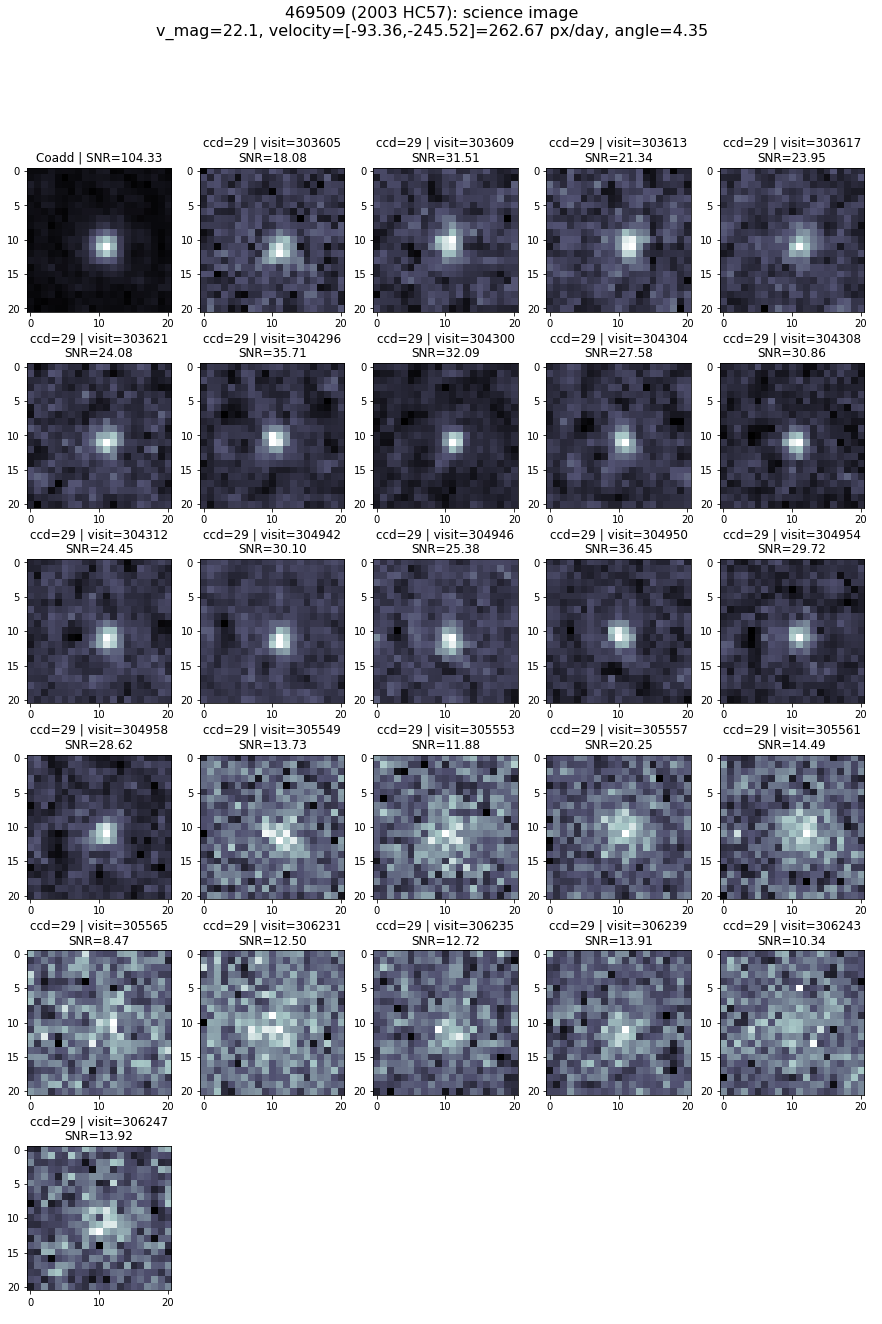

In [137]:

coaddData = makeStamps(allResults,dataPath,stampSize=[21,21],numCols=5)
#plt.savefig('2013_GT136_Sample.png')
#_ = makeStamps(allResults,dataPath,imagePlane='mask')
#_ = makeStamps(results,dataPath,imagePlane='variance')



In [35]:
from skimage import measure
center_thresh = 0.03
x_peak_offset, y_peak_offset = [2,2]
stamps = coaddData
s = stamps - np.min(stamps)
s /= np.sum(s)
s = np.array(s, dtype=np.dtype('float64')).reshape(21,21)
mom = measure.moments_central(s, center=(10,10))
mom_list = [mom[2, 0], mom[0, 2], mom[1, 1], mom[1, 0], mom[0, 1]]
peak_1, peak_2 = np.where(s == np.max(s))

In [36]:
print(mom_list)
print(peak_1, peak_2)

[25.14556224422995, 25.078051695396425, 1.9718366023153067, 0.2750369818531908, 0.24856384735903703]
[11] [11]


In [19]:
[[1,2],[2,3]]+[[3,4],[4,5]]

[[1, 2], [2, 3], [3, 4], [4, 5]]